In [1]:
!pip install opendatasets
!pip install pandas

import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.data as tf_data
import matplotlib.pyplot as plt
import re
from keras.layers import TextVectorization
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator
import opendatasets as od
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from typing import Tuple
import os

In [2]:
od.download(
    "https://www.kaggle.com/datasets/kouroshalizadeh/history-of-philosophy")
nltk.download('punkt')

Dataset URL: https://www.kaggle.com/datasets/kouroshalizadeh/history-of-philosophy


100%|██████████| 55.1M/55.1M [00:02<00:00, 27.9MB/s]


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Here we initialize some utilities that will come useful later, alongside the function that let's us get the dataset, both reduced and not, ready for training and evaluation

In [3]:
SCHOOLS = ['analytic','aristotle','german_idealism',
           'plato','continental','phenomenology',
           'rationalism','empiricism','feminism',
           'capitalism','communism','nietzsche',
           'stoicism']

In [4]:
# Load your datasets
def getData(validation_size:float=0.2,
            test_size:float=0.1,
            from_folder:str='',
            min_chars:int=None,
            max_chars:int=None)-> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    df = pd.read_csv(os.path.join(from_folder,'philosophy_data.csv'))
    development, test = train_test_split(df, test_size=test_size, stratify=df['school'], random_state=42, shuffle=True)
    # Split validation and train from train
    if validation_size == 0:
        return development, None, test
    train, validation = train_test_split(development,
                                         test_size=validation_size/(1 - test_size),
                                         stratify=development['school'],
                                         random_state=42,
                                         shuffle=True)

    train = reduceDataset(train, min_chars, max_chars)
    validation = reduceDataset(validation, min_chars, max_chars)
    test = reduceDataset(test, min_chars, max_chars)
    return train, validation, test

def reduceDataset(df:pd.DataFrame,
                  min_chars:int=None,
                  max_chars:int=None)-> pd.DataFrame:
    if min_chars is not None:
        df = df[(df['sentence_length'] >= min_chars)]
    if max_chars is not None:
        df = df[(df['sentence_length'] <= max_chars)]
    return df

In [5]:
!wget https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
!unzip -q glove.6B.zip

--2024-05-29 13:20:43--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.12MB/s    in 2m 39s  

2024-05-29 13:23:22 (5.17 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



We create the embeddings index from the pretrained GloVe embeddings, with vector dimension 100, so that we may create the embedding matrices later 

In [6]:
path_to_glove_file = "glove.6B.100d.txt"

# For each line in the glove file, take the words with their coefficients and map every coefficient to their respective word
embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [4]:
# Get full split
train, validation, test = getData(from_folder = 'history-of-philosophy')

In [8]:
# Get the reduced split
rtrain, rval, rtest = getData(from_folder = 'history-of-philosophy', min_chars = 84)

We define two sets of training, validation and test, one with all the sentences and the other without the sentences that contain less than 85 character so that we may test our hypotheses.
We also encode the labels to facilitate training.
After getting the sets of data, both reduced and not, we create and adapt the TextVectorization layer for both the full and reduced datasets, which will pass its output to the embedding layer.

In [9]:
vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=100)
# create tr
train = [train['sentence_str'],train['school']]
# get the sentences
sentences,_ = train
# reshape so we can create a Dataset object to adapt the vectorizer on
sentences = np.array(sentences).reshape(-1,1)
text_ds = tf.data.Dataset.from_tensor_slices(sentences).batch(128)
vectorizer.adapt(text_ds)

In [10]:
# create vl
validation = [validation['sentence_str'],validation['school']]
# take out the sentences and the schools so we can put them into a Dataset object later on
val_sentences,val_schools = validation
val_sentences = np.array(val_sentences).reshape(-1,1)

In [11]:
# Same process for reduced dataset
rvectorizer = TextVectorization(max_tokens=20000, output_sequence_length=200)
rtrain = [rtrain['sentence_str'],rtrain['school']]
rsentences,rschools = rtrain
rsentences = np.array(rsentences).reshape(-1,1)
rtext_ds = tf.data.Dataset.from_tensor_slices(rsentences).batch(128)
rvectorizer.adapt(rtext_ds)
rval = [rval['sentence_str'],rval['school']]
rval_sentences,rval_schools = rval
rval_sentences = np.array(rval_sentences).reshape(-1,1)

In [12]:
# Encode the schools so we can put them into a Dataset object and predict them correctly.
_,schools = train
lb_encoder = LabelEncoder()
schools = lb_encoder.fit_transform(schools)
schools = to_categorical(schools)

In [13]:
# same thing we did above
rschools = lb_encoder.fit_transform(rschools)
rschools = to_categorical(rschools)

In [14]:
# same thing we did above this time for validation
val_schools = lb_encoder.fit_transform(val_schools)
val_schools = to_categorical(val_schools)

In [15]:
# same thing we did above this time for validation
rval_schools = lb_encoder.fit_transform(rval_schools)
rval_schools = to_categorical(rval_schools)

We define the word indexes, both reduced and not, so that we may construct the embedding matrices from the pretrained GloVe embeddings. Done that, we use the embeddings matrices to create the keras Embedding layers for our networks.

In [16]:
# just put the vocabulary in a dictionary so we have a word index, which we'll use to construct the embedding matrix.
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [17]:
# just put the vocabulary in a dictionary so we have a word index, which we'll use to construct the embedding matrix
rvoc = rvectorizer.get_vocabulary()
rword_index = dict(zip(rvoc, range(len(rvoc))))

In [18]:
# +2 so we add padding and "out of vocabulary"
num_tokens = len(vectorizer.get_vocabulary()) + 2
embedding_dim = 100 # dimension of the glove vectors
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))


Converted 18798 words (1202 misses)


In [19]:
# Same process as above
num_tokens = len(rvectorizer.get_vocabulary()) + 2
hits = 0
misses = 0

# Prepare embedding matrix
rembedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in rword_index.items():
    rembedding_vector = embeddings_index.get(word)
    if rembedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        rembedding_matrix[i] = rembedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))


Converted 18822 words (1178 misses)


In [20]:
from keras.layers import Embedding

# Create embedding layer using the embedding matrix we created above
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    trainable=True,
)
embedding_layer.build((1,))
embedding_layer.set_weights([embedding_matrix])

In [21]:
from keras.layers import Embedding

# Creae embedding layer using the embedding matrix we created above
rembedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    trainable=True,
)
rembedding_layer.build((1,))
rembedding_layer.set_weights([rembedding_matrix])

In [22]:
print(embedding_matrix.shape)
print(rembedding_matrix.shape)

(20002, 100)
(20002, 100)


We extend the `BaseEstimator` class to declare our RNN model so that we may eventually launch a Gridsearch with sklearn, if need arises.
Our architecture is constructed as a feedforward RNN with:
- An encoder, which will be a text vectorization layer.
- An embedding layer, pretrained, of output dimension 100 (already prepared)
- A bidirectional LSTM layer with 32 (64) units
- A dense layer with softmax activation function to get the network output.

Categorical crossentropy is used as loss function, with the Adam optimizer (which revealed itself to be the best after multiple attempts at the task)

In [23]:
import keras
from keras import layers

class RNN(BaseEstimator):
    def __init__(self, output_units, embedding_layer):
        int_sequences_input = keras.Input(shape=(1,), dtype=tf.string)
        vectorization_layer = vectorizer(int_sequences_input)
        embedded_sequences = embedding_layer(vectorization_layer)
        x = layers.Bidirectional(layers.LSTM(64))(embedded_sequences)
        preds = layers.Dense(activation='softmax', units=output_units)(x) # 13 for the number of schools
        self.model = keras.Model(int_sequences_input,preds)
        self.model.compile(loss=keras.losses.CategoricalCrossentropy(),
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

    def fit(
        self,
        x=None,
        y=None,
        batch_size=None,
        epochs=1,
        verbose='auto',
        callbacks=None,
        validation_split=0.0,
        validation_data=None,
        shuffle=True,
        class_weight=None,
        sample_weight=None,
        initial_epoch=0,
        steps_per_epoch=None,
        validation_steps=None,
        validation_batch_size=None,
        validation_freq=1
    ):
        return self.model.fit(
            x=x,
            y=y,
            batch_size=batch_size,
            epochs=epochs,
            verbose=verbose,
            callbacks=callbacks,
            validation_split=validation_split,
            validation_data=validation_data,
            shuffle=shuffle,
            class_weight=class_weight,
            sample_weight=sample_weight,
            initial_epoch=initial_epoch,
            steps_per_epoch=steps_per_epoch,
            validation_steps=validation_steps,
            validation_batch_size=validation_batch_size,
            validation_freq=validation_freq
            )


    def predict(self, X):
        return self.model.predict(X)

    def evaluate(self, X):
        return self.model.evaluate(X)


We get two models with the same architecture, one to be trained on the full dataset and the other on the reduced one.

In [24]:
rnn = RNN(13, embedding_layer)

In [25]:
r_rnn = RNN(13, rembedding_layer)

In [26]:
rnn.model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 100)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 100, 100)          2000200   
                                                                 
 bidirectional (Bidirection  (None, 128)               84480     
 al)                                                             
                                                                 
 dense (Dense)               (None, 13)                1677      
                                                                 
Total params: 2086357 (7.96 MB)
Trainable params: 2086357 (7.

In [27]:
r_rnn.model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 100)               0         
 ctorization)                                                    
                                                                 
 embedding_1 (Embedding)     (None, 100, 100)          2000200   
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               84480     
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 13)                1677      
                                                                 
Total params: 2086357 (7.96 MB)
Trainable params: 2086357 (

We prepare the datasets

In [28]:
dataset = tf.data.Dataset.from_tensor_slices((sentences, schools)).batch(128)

In [29]:
r_dataset = tf.data.Dataset.from_tensor_slices((rsentences,rschools)).batch(128)

In [30]:
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_schools)).batch(128)

In [31]:
rval_dataset = tf.data.Dataset.from_tensor_slices((rval_sentences, rval_schools)).batch(128)

In [32]:
for layer in rnn.model.layers:
    print(layer.output_shape)

[(None, 1)]
(None, 100)
(None, 100, 100)
(None, 128)
(None, 13)


We prepare the callback and start fitting the models over their respective datasets

In [33]:
# prepare early stopping with patience 2

checkpoint_filepath = '/tmp/ckpt/checkpoint.model.keras'

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs'),
        tf.keras.callbacks.ModelCheckpoint(checkpoint_filepath, verbose=1, save_best_only=True)]

In [34]:
rnn.fit(dataset, epochs = 12, validation_data = val_dataset, callbacks = callbacks)

Epoch 1/12
1974/1974 [==============================] - ETA: 0s - loss: 1.1923 - accuracy: 0.6144
Epoch 1: val_loss improved from inf to 0.87372, saving model to /tmp/ckpt/checkpoint.model.keras
1974/1974 [==============================] - 111s 54ms/step - loss: 1.1923 - accuracy: 0.6144 - val_loss: 0.8737 - val_accuracy: 0.7209
Epoch 2/12
1974/1974 [==============================] - ETA: 0s - loss: 0.7262 - accuracy: 0.7688
Epoch 2: val_loss improved from 0.87372 to 0.78009, saving model to /tmp/ckpt/checkpoint.model.keras
1974/1974 [==============================] - 35s 17ms/step - loss: 0.7262 - accuracy: 0.7688 - val_loss: 0.7801 - val_accuracy: 0.7510
Epoch 3/12
1972/1974 [============================>.] - ETA: 0s - loss: 0.5939 - accuracy: 0.8103
Epoch 3: val_loss improved from 0.78009 to 0.75035, saving model to /tmp/ckpt/checkpoint.model.keras
1974/1974 [==============================] - 37s 19ms/step - loss: 0.5938 - accuracy: 0.8103 - val_loss: 0.7503 - val_accuracy: 0.7634
E

In [35]:
r_rnn.fit(r_dataset, epochs = 12, validation_data = rval_dataset, callbacks = callbacks)

Epoch 1/12
1400/1400 [==============================] - ETA: 0s - loss: 1.3321 - accuracy: 0.5603
Epoch 1: val_loss did not improve from 0.75035
1400/1400 [==============================] - 79s 52ms/step - loss: 1.3321 - accuracy: 0.5603 - val_loss: 0.8571 - val_accuracy: 0.7268
Epoch 2/12
1398/1400 [============================>.] - ETA: 0s - loss: 0.6791 - accuracy: 0.7838
Epoch 2: val_loss improved from 0.75035 to 0.71613, saving model to /tmp/ckpt/checkpoint.model.keras
1400/1400 [==============================] - 29s 21ms/step - loss: 0.6790 - accuracy: 0.7839 - val_loss: 0.7161 - val_accuracy: 0.7746
Epoch 3/12
1399/1400 [============================>.] - ETA: 0s - loss: 0.4974 - accuracy: 0.8436
Epoch 3: val_loss improved from 0.71613 to 0.68225, saving model to /tmp/ckpt/checkpoint.model.keras
1400/1400 [==============================] - 33s 23ms/step - loss: 0.4973 - accuracy: 0.8436 - val_loss: 0.6823 - val_accuracy: 0.7887
Epoch 4/12
1399/1400 [============================>.

We define the scoring functions to get the confusion matrices and infer our metrics for evaluation

In [36]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, f1_score, precision_score, recall_score

def scorePhilosophy(prediction: 'list[str]', ground_truth: 'list[str]', saveName:str=None, showConfusionMatrix:bool=False) -> None:
    cm = confusion_matrix(ground_truth, prediction, labels=SCHOOLS, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=SCHOOLS)
    disp.plot()
    plt.gcf().set_size_inches(12, 12)
    plt.xticks(rotation=45)
    if saveName:
        plt.savefig(saveName, dpi=300)
    if showConfusionMatrix:
        plt.show()
    #classificaiton report
    print(classification_report(ground_truth, prediction, target_names=SCHOOLS))
    print(f"micro f1: {f1_score(ground_truth, prediction, average='micro'):.2f}")
    print(f"micro precision: {precision_score(ground_truth, prediction, average='micro'):.2f}")
    print(f"micro recall: {recall_score(ground_truth, prediction, average='micro'):.2f}")

Having trained the model and noted that the reduced one performed better we now pass their prediction over the validation set to the scoring function we declared before and print out both the metrics and the confusion matrix

4/4 [==============================] - 1s 10ms/step


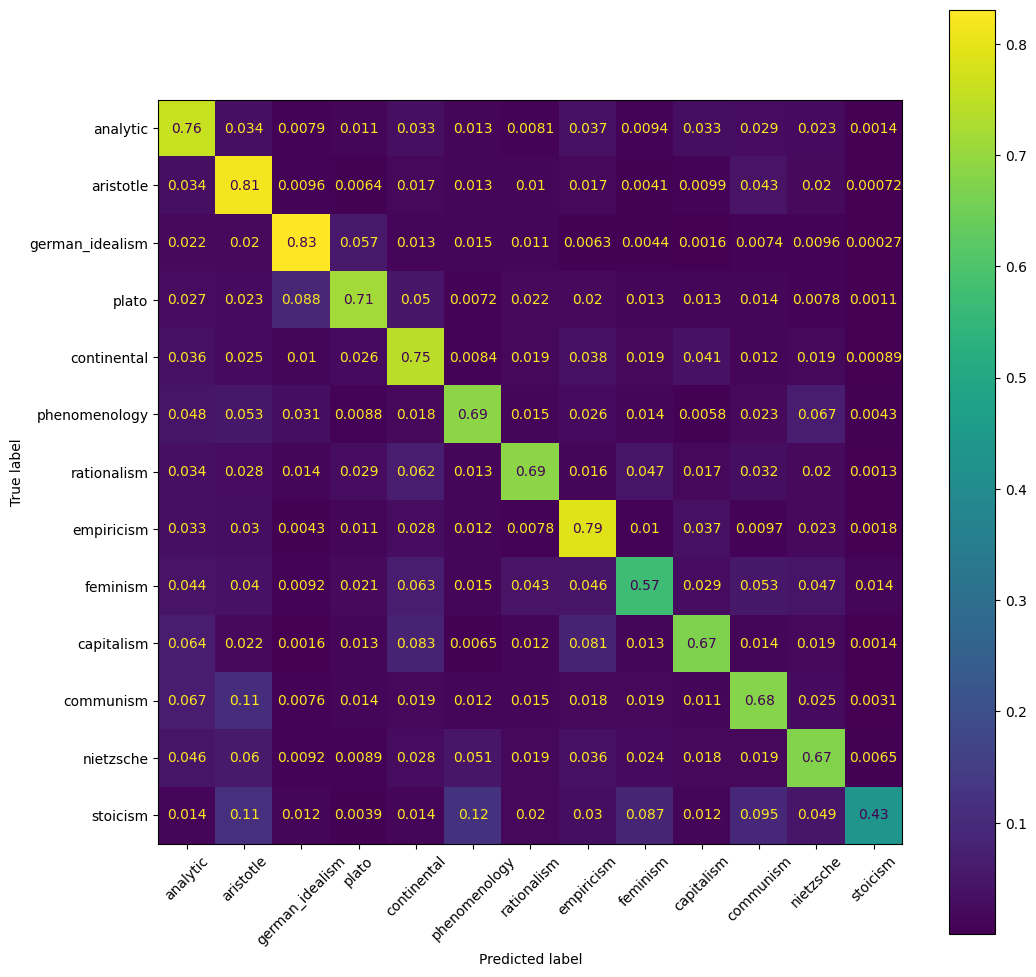

                 precision    recall  f1-score   support

       analytic       0.77      0.76      0.76     11085
      aristotle       0.75      0.81      0.78      9756
german_idealism       0.73      0.67      0.70      5715
          plato       0.77      0.68      0.72      7673
    continental       0.69      0.75      0.72      6756
  phenomenology       0.77      0.79      0.78      8427
    rationalism       0.60      0.57      0.59      2709
     empiricism       0.77      0.83      0.80      3639
       feminism       0.65      0.67      0.66      4590
     capitalism       0.72      0.69      0.70      3986
      communism       0.70      0.71      0.71      3592
      nietzsche       0.73      0.69      0.71      3727
       stoicism       0.56      0.43      0.49       507

       accuracy                           0.73     72162
      macro avg       0.71      0.70      0.70     72162
   weighted avg       0.73      0.73      0.73     72162

micro f1: 0.73
micro precisi

In [37]:
predictions = []
y_true = []
for batch in val_dataset:
    # Predict the validation set
    x_batch, y_batch = batch
    batch_predictions = r_rnn.predict(x_batch)
    # convert the predicted probabilities into class labels
    batch_predictions = np.argmax(batch_predictions, axis=1)
    # Map Class Labels to School Names
    batch_predictions = [SCHOOLS[pred] for pred in batch_predictions]
    # Process true labels in the same way
    y_batch = np.argmax(y_batch, axis=1)
    y_batch = [SCHOOLS[pred] for pred in y_batch]
    # add the mapped labels to their respective lists
    predictions.extend(batch_predictions)
    y_true.extend(y_batch)

# Get the scores
scorePhilosophy(predictions, y_true, "cm", True)

4/4 [==============================] - 1s 11ms/step


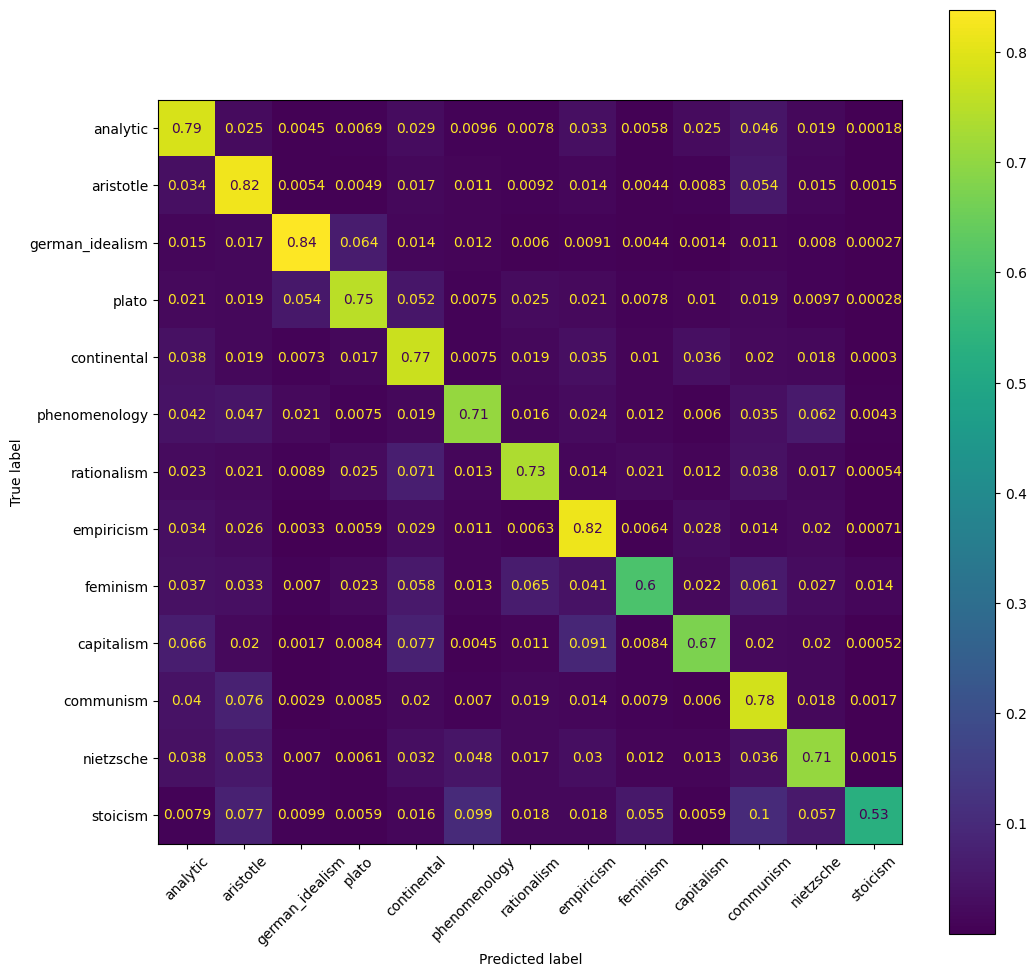

                 precision    recall  f1-score   support

       analytic       0.80      0.79      0.79     11085
      aristotle       0.79      0.82      0.81      9756
german_idealism       0.77      0.67      0.72      5715
          plato       0.73      0.78      0.76      7673
    continental       0.70      0.77      0.74      6756
  phenomenology       0.79      0.82      0.80      8427
    rationalism       0.73      0.60      0.66      2709
     empiricism       0.84      0.84      0.84      3639
       feminism       0.70      0.71      0.70      4590
     capitalism       0.76      0.71      0.73      3986
      communism       0.76      0.75      0.76      3592
      nietzsche       0.73      0.73      0.73      3727
       stoicism       0.72      0.53      0.61       507

       accuracy                           0.76     72162
      macro avg       0.76      0.73      0.74     72162
   weighted avg       0.76      0.76      0.76     72162

micro f1: 0.76
micro precisi

In [38]:
# same as above
predictions = []
y_true = []
for batch in val_dataset:
    x_batch, y_batch = batch
    batch_predictions = rnn.predict(x_batch)
    batch_predictions = np.argmax(batch_predictions, axis=1)
    batch_predictions = [SCHOOLS[pred] for pred in batch_predictions]
    y_batch = np.argmax(y_batch, axis=1)
    y_batch = [SCHOOLS[pred] for pred in y_batch]
    predictions.extend(batch_predictions)
    y_true.extend(y_batch)


scorePhilosophy(predictions, y_true, "cm", True)

1/1 [==============================] - 0s 31ms/step


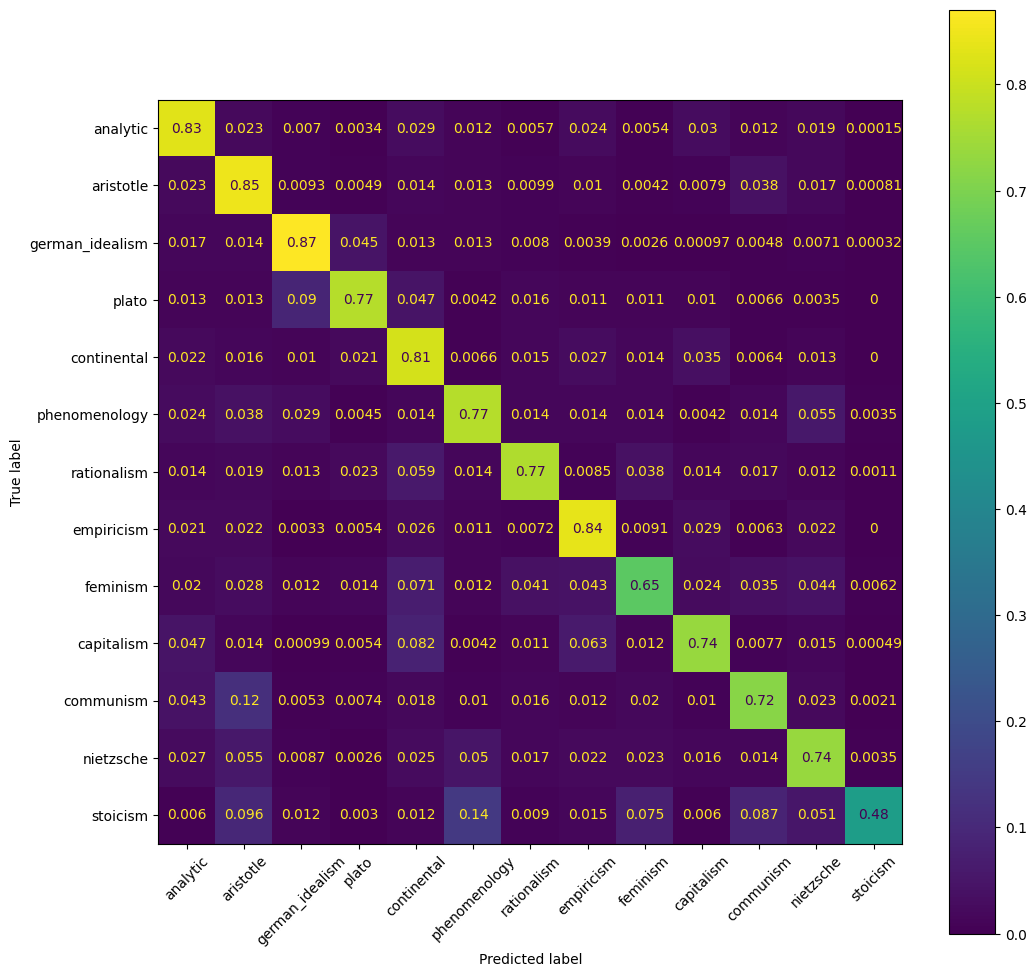

                 precision    recall  f1-score   support

       analytic       0.84      0.83      0.83      6841
      aristotle       0.81      0.85      0.83      7386
german_idealism       0.78      0.74      0.76      4049
          plato       0.81      0.72      0.76      4322
    continental       0.75      0.81      0.78      5190
  phenomenology       0.86      0.84      0.85      6668
    rationalism       0.60      0.65      0.63      1447
     empiricism       0.81      0.87      0.84      3106
       feminism       0.73      0.74      0.73      3464
     capitalism       0.78      0.77      0.78      3105
      communism       0.80      0.77      0.79      2593
      nietzsche       0.78      0.77      0.77      2702
       stoicism       0.75      0.48      0.59       333

       accuracy                           0.79     51206
      macro avg       0.78      0.76      0.76     51206
   weighted avg       0.80      0.79      0.79     51206

micro f1: 0.79
micro precisi

In [39]:
# same as above
predictions = []
y_true = []
for batch in rval_dataset:
    x_batch, y_batch = batch
    batch_predictions = r_rnn.predict(x_batch)
    batch_predictions = np.argmax(batch_predictions, axis=1)
    batch_predictions = [SCHOOLS[pred] for pred in batch_predictions]
    y_batch = np.argmax(y_batch, axis=1)
    y_batch = [SCHOOLS[pred] for pred in y_batch]
    predictions.extend(batch_predictions)
    y_true.extend(y_batch)


scorePhilosophy(predictions, y_true, "cm", True)

4/4 [==============================] - 0s 9ms/step


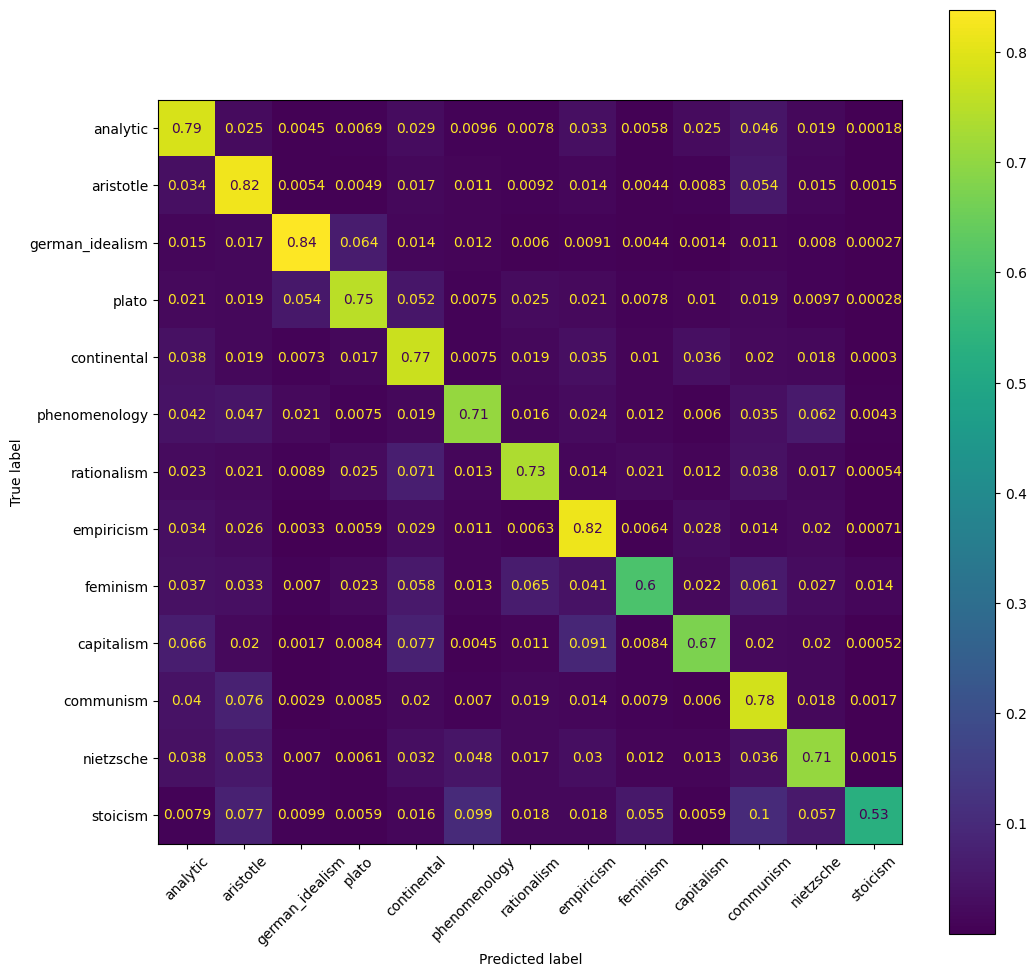

                 precision    recall  f1-score   support

       analytic       0.80      0.79      0.79     11085
      aristotle       0.79      0.82      0.81      9756
german_idealism       0.77      0.67      0.72      5715
          plato       0.73      0.78      0.76      7673
    continental       0.70      0.77      0.74      6756
  phenomenology       0.79      0.82      0.80      8427
    rationalism       0.73      0.60      0.66      2709
     empiricism       0.84      0.84      0.84      3639
       feminism       0.70      0.71      0.70      4590
     capitalism       0.76      0.71      0.73      3986
      communism       0.76      0.75      0.76      3592
      nietzsche       0.73      0.73      0.73      3727
       stoicism       0.72      0.53      0.61       507

       accuracy                           0.76     72162
      macro avg       0.76      0.73      0.74     72162
   weighted avg       0.76      0.76      0.76     72162

micro f1: 0.76
micro precisi

In [40]:
# same as above
predictions = []
y_true = []
for batch in val_dataset:
    x_batch, y_batch = batch
    batch_predictions = rnn.predict(x_batch)
    batch_predictions = np.argmax(batch_predictions, axis=1)
    batch_predictions = [SCHOOLS[pred] for pred in batch_predictions]
    y_batch = np.argmax(y_batch, axis=1)
    y_batch = [SCHOOLS[pred] for pred in y_batch]
    predictions.extend(batch_predictions)
    y_true.extend(y_batch)


scorePhilosophy(predictions, y_true, "cm", True)

In [41]:
rnn.model.save("RnnPretFull.keras")
r_rnn.model.save("RnnPretReduced.keras")